In [ ]:
#!pip install opendatasets # download the files to local drive

#import opendatasets as od

#od.download("https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

Skipping, found downloaded files in "./tuberculosis-tb-chest-xray-dataset" (use force=True to force download)


In [ ]:
import cv2 # For Reading Image
import numpy as np # For Manipulating Imag e Matrix
import matplotlib.pyplot as plt # For Showing Image
import skimage #For Feature Extraction
from skimage import feature, img_as_ubyte # For LBP feature extraction
import math # For Math
import os #Access Folder


filename_normal = "normal.png"
filename_tbc = "tbc.png"

img_normal = cv2.imread(filename_normal) # Read Image
if img_normal is None:
    print(f"Error: Could not load image {filename_normal}. Please ensure it exists in the correct directory.")
else:
    img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY) # Change the color map

img_tbc = cv2.imread(filename_tbc) # Read Image
if img_tbc is None:
    print(f"Error: Could not load image {filename_tbc}. Please ensure it exists in the correct directory.")
else:
    img_tbc = cv2.cvtColor(img_tbc, cv2.COLOR_BGR2GRAY) # Change the color map

In [ ]:
def show_test(before, after, title1="TBC", title2="Normal"): # Helper function to check the before and after of the image processing (Only for the test)
  plt.figure(figsize=(10,5))

   # Show original
  plt.subplot(1,2,1)
  plt.imshow(before, cmap='gray', vmin=0, vmax=255) #vmin and max to preserve original image's contrast
  plt.title(title1)
  plt.axis("off")

  # Show processed
  plt.subplot(1,2,2)
  plt.imshow(after, cmap='gray', vmin=0, vmax=255)
  plt.title(title2)
  plt.axis("off")

  plt.show()

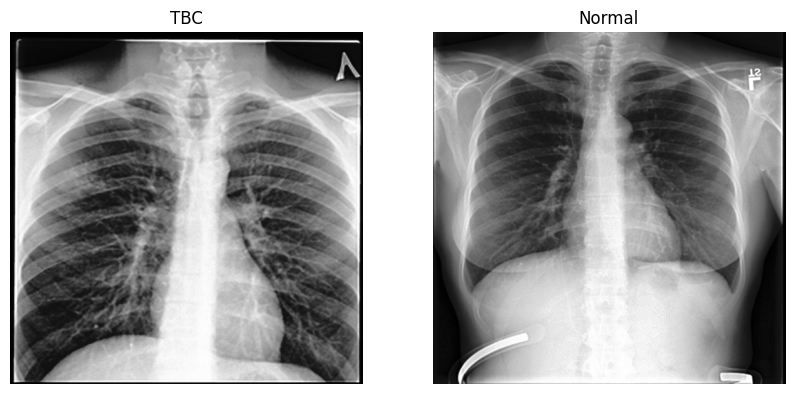

In [ ]:
def enhance_image(img):
  #Apply Gaussian Smoothing with a kernel of 5x5
  img_gaussian = cv2.GaussianBlur(img, (5, 5), 0)
  #Additionally, Apply Laplacian Smoothing to highlight edge
  img_laplacian = cv2.Laplacian(img_gaussian, cv2.CV_64F)
  #Sharpen Image by adding the edges from Laplacian Smoothing
  img_sharpened = cv2.convertScaleAbs(img_gaussian - img_laplacian)
  #Apply Histogram Equilization to Increase the Image's Contrast
  img_hist = cv2.equalizeHist(img_sharpened)
  return img_hist

img_tbc_enhanced = enhance_image(img_tbc)
img_normal_enhanced = enhance_image(img_normal)
show_test(img_tbc_enhanced, img_normal_enhanced)

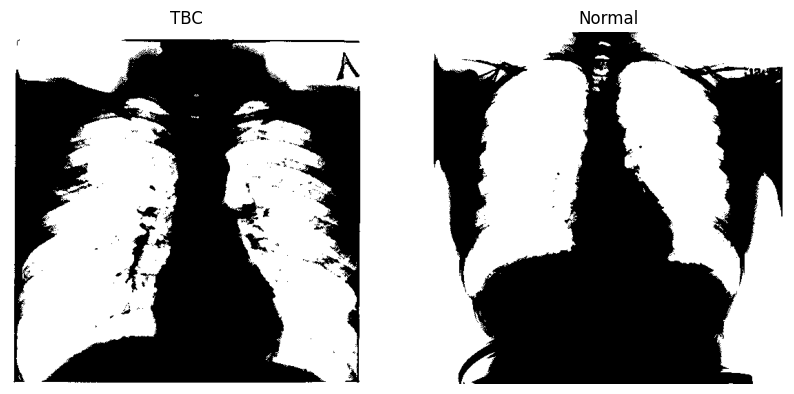

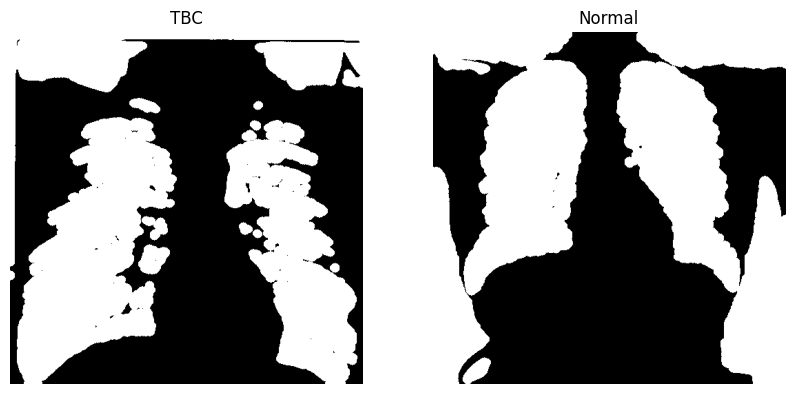

In [ ]:
def segment_image(img):
  #Use Otsu Segmentation to Segment both Lungs
  ret, img = cv2.threshold(img, 0, 255,cv2.THRESH_OTSU)
  #Inverse the segmentation so we get the lungs as the foreground
  img = cv2.bitwise_not(img)
  return img

img_tbc_segmented = segment_image(img_tbc_enhanced)
img_normal_segmented = segment_image(img_normal_enhanced)

show_test(img_tbc_segmented, img_normal_segmented)

def morphological_process(img):
  #Create Elipse Kernel to use in the Opening Algorithm
  kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))

  #Execute Opening Algorithm to remove noise and seperate object
  img_normal_opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_opening)
  return img_normal_opened

img_tbc_opened = morphological_process(img_tbc_segmented)
img_normal_opened = morphological_process(img_normal_segmented)
show_test(img_tbc_opened, img_normal_opened)

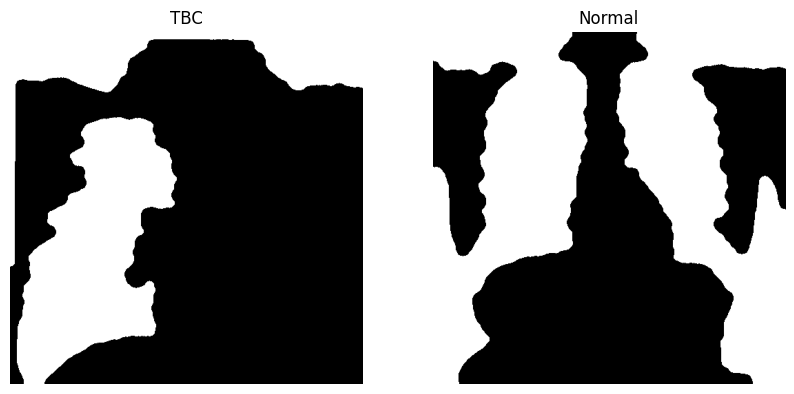

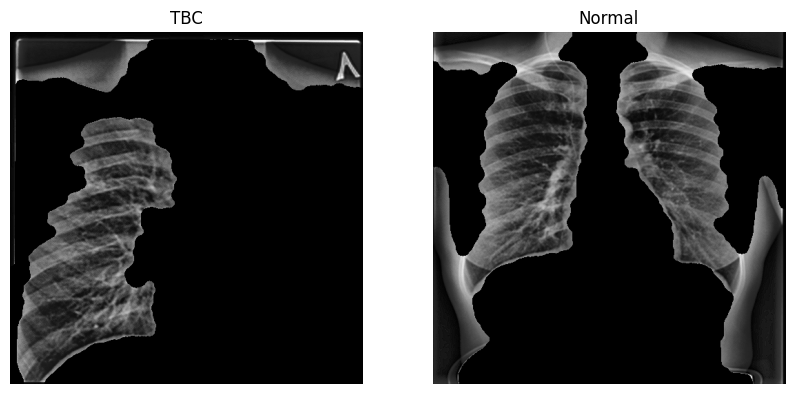

In [ ]:
def select_lungs(segmented_image):
  # Find all connected components
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, 8, cv2.CV_32S)

  h, w = segmented_image.shape

  # The first component is usually the background, so we skip it.
  candidates = []
  for i in range(1, num_labels):
    x = centroids[i][0]
    y = centroids[i][1]
    area = stats[i, cv2.CC_STAT_AREA]

    # Lungs must be inside central region of the chest
    if w * 0.2 < x < w * 0.8:   # keep only components near the center
      candidates.append((area, i))

  #Sort by Area
  candidates.sort(key=lambda x: x[0], reverse=True)

  # Create blank images to hold the selected lungs
  lung1_image = np.zeros_like(segmented_image, dtype=np.uint8)
  lung2_image = np.zeros_like(segmented_image, dtype=np.uint8)

  # Select the two largest components (assuming they are the two lungs)
  if len(candidates) >= 1:
    largest_component_id = candidates[0][1]
    lung1_image[labels == largest_component_id] = 255
  if len(candidates) >= 2:
    second_largest_component_id = candidates[1][1]
    lung2_image[labels == second_largest_component_id] = 255

  return lung1_image, lung2_image

def get_mask(img):
  # Select lungs for TBC
    lung1, lung2 = select_lungs(img)
    lungs = cv2.add(lung1, lung2)

    #Create Elipse Kernel to use in the Closing Algorithm
    kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19, 19))
    #Execute Closing Algorithm to fill in holes
    img = cv2.morphologyEx(lungs, cv2.MORPH_CLOSE, kernel_closing)
    return img

img_tbc_masked = get_mask(img_tbc_opened)
img_normal_masked = get_mask(img_normal_opened)

show_test(img_tbc_masked, img_normal_masked)

def apply_mask(img, mask):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

  # Apply CLAHE to the enhanced images
  img = clahe.apply(img)

  #Apply Mask using Bitwise And (The arguments are repeated since the function needs two arguments)
  img = cv2.bitwise_and(img, img, mask=mask)
  return img

tbc_masked = apply_mask(img_tbc_enhanced, img_tbc_masked)
normal_masked = apply_mask(img_normal_enhanced, img_normal_masked)
show_test(tbc_masked, normal_masked)

In [ ]:
#Extract LBP Feature
def extract_lbp(image, P=8, R=1):
    lbp = feature.local_binary_pattern(image, P, R, method="uniform")
    # Histogram (59 bins for uniform LBP)
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= hist.sum()  # normalize
    return hist

#Extract GLCM Feature
def extract_glcm(image):
  image = img_as_ubyte(image) #ensure image is in the correct format (graysclae 0-255)
  distances = [1, 2, 3] #takes texture from multiple spatial scales
  angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] #devicne used angles since textures change depending on the direction
  glcm = feature.graycomatrix(image,
                              distances=distances,
                              angles=angles,
                              levels=256,
                              symmetric=True,
                              normed=True) #Computes GLCM
  features = []
  #Calculate these Haralick features (might add/remove some later)
  props = ['ASM', 'variance', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'entropy']

  for prop in props: #Extract Values for each property
    values = feature.graycoprops(glcm, prop).flatten()
    features.extend(values)

  return np.array(features) #Return as an numpy array

#Extract HOG Features
def extract_hog(image):
  #Calculated Histogram of Oriented Gradients
  hog = skimage.feature.hog(image, orientations=9,
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2,2),
                            block_norm='L2-Hys',
                            transform_sqrt = True,
                            feature_vector=True)
  return hog

#Use all prev functions to get the final vector
def extract_features(image):
  lbp_features = extract_lbp(image)
  glcm_features = extract_glcm(image)
  hog_features = extract_hog(image)

  final_vector = np.concatenate((lbp_features, glcm_features, hog_features)) #Combine the vectors
  return final_vector

tbc_features = extract_features(tbc_masked)
normal_features = extract_features(normal_masked)
print(f"TBC Features: {tbc_features.shape}")
print(f"Normal Features: {normal_features.shape}")


TBC Features: (142990,)
Normal Features: (142990,)


In [ ]:
def process_image(img):
  #Image Acquisition
  if len(img.shape) == 3: #Check if already Grayscale, might remove later
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #Image Enhancement
  img_enhanced = enhance_image(img)
  #Image Segmentation
  img = segment_image(img_enhanced)
  #Morphological Processes
  img = morphological_process(img)
  #Getting andApplying Mask
  img = get_mask(img)
  img = apply_mask(img_enhanced, img)
  return img

def process_and_get_vector(img):
  img = process_image(img)
  return extract_features(img)

img_test = process_image(img_tbc)
img_test2 = process_image(img_normal)
print(f"TBC Features: {process_and_get_vector(img_tbc)}")
print(f"Normal Features: {process_and_get_vector(img_normal)}")

TBC Features: [0.0233345  0.02325821 0.01470947 ... 0.         0.         0.        ]
Normal Features: [0.03165436 0.03288269 0.02584457 ... 0.         0.         0.46490317]


In [ ]:
import os

#Set File Location
normal_dir = '/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'
tbc_dir = '/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis'

#Set Features and Labels to be trained
X = []   # feature vectors
y = []   # labels (0 = normal, 1 = TB)

# Verify whether the directories exists
print(f"Normal directory exists: {os.path.isdir(normal_dir)}")
print(f"Tuberculosis directory exists: {os.path.isdir(tbc_dir)}")

#Preprocess images
def process_folder(folder_path, label):
  image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')] #Get all image files
  total = len(image_files)
  print(f"Found {total} images in {folder_path}.")


  for i, filename in enumerate(image_files, start=1): #Process every image in a specific directory
    image_path = os.path.join(folder_path, filename)
    img = cv2.imread(image_path)
    if img is None:
      print(f"{image_path} fail")
      continue
    features = process_and_get_vector(img)
    X.append(features)
    y.append(label)
    print(f"Processed {filename}  ({i}/{total})")

#Process both folders
process_folder(normal_dir, label=0)
process_folder(tbc_dir, label=1)

#Save features and labels to use later.
np.save("features.npy", np.array(X))
np.save("labels.npy", np.array(y))

Normal directory exists: True
Tuberculosis directory exists: True
Found 3500 images in /content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.
Processed Normal-2934.png  (1/3500)
Processed Normal-845.png  (2/3500)
Processed Normal-2852.png  (3/3500)
Processed Normal-3096.png  (4/3500)
Processed Normal-39.png  (5/3500)
Processed Normal-2565.png  (6/3500)
Processed Normal-3173.png  (7/3500)
Processed Normal-89.png  (8/3500)
Processed Normal-1428.png  (9/3500)
Processed Normal-3499.png  (10/3500)
Processed Normal-850.png  (11/3500)
Processed Normal-3475.png  (12/3500)
Processed Normal-1597.png  (13/3500)
Processed Normal-2311.png  (14/3500)
Processed Normal-663.png  (15/3500)
Processed Normal-1769.png  (16/3500)
Processed Normal-3240.png  (17/3500)
Processed Normal-142.png  (18/3500)
Processed Normal-1584.png  (19/3500)
Processed Normal-2449.png  (20/3500)
Processed Normal-2234.png  (21/3500)
Processed Normal-3336.png  (22/3500)
Processed Normal-1753.png  (23/350

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

X = np.array(X)
y = np.array(y)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
joblib.dump(model, "model.pkl")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9678571428571429


['model.pkl']

In [ ]:
import os
import cv2
import joblib

model_path = "model.pkl"
filename = "test.png"
model = joblib.load(model_path)

# Read image
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (512, 512))
feature_vector = process_and_get_vector(img)
prediction = model.predict([feature_vector])
if (prediction == 1):
    print("TBC")
else:
    print("Normal")

Normal


Accuracy: 0.9678571428571429

Confusion Matrix:
 [[694   9]
 [ 18 119]]

Precision: 0.9296875
Recall: 0.8686131386861314
F1 Score: 0.8981132075471698

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       703
           1       0.93      0.87      0.90       137

    accuracy                           0.97       840
   macro avg       0.95      0.93      0.94       840
weighted avg       0.97      0.97      0.97       840

ROC-AUC Score: 0.9926020911422371


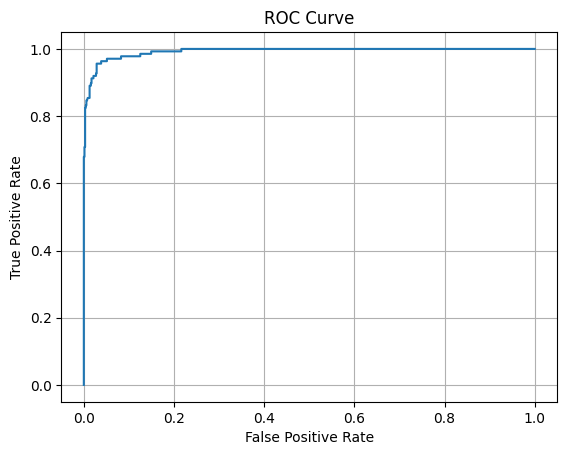

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Precision, Recall, F1
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", auc)

# OPTIONAL: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.show()